In [1]:
##############################################################################
#####################################################################
#####################################################################
#
# STEP 3 - DATE DEPENDENCY:
#
#                year and month ⇔ sold-houses prices
#
#####################################################################
##############################################################################

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import arange
import math

import seaborn as sns
sns.set_style("white")

import scipy as sp
from scipy import linalg, optimize

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import collections
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.dates import DateFormatter

import calendar
import datetime as dt
fromtimestamp = dt.datetime.fromtimestamp

In [3]:
 # importing input data
df = pd.read_csv("../data/train.csv")
    # confirm
df.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [4]:
# safety-first: 
    # copy df into w(orking)df:
wdf = df.copy()

    # make sure vals in col"id" are all unique:
len(wdf['Id'].unique())==len(wdf)

True

In [5]:
##############################################################################
##############################################################################
#
# STEP 3-1: OVERVIEW 
#
#         DATE-PRICE ALL VALUES
#
###################################################
###################################################
#

sold = wdf.get(['Id','SalePrice','YrSold','MoSold'])   
#         ^ get cols named SalePrice, MoSold, YrSold + review data to confirm significance > data seems to meet expectations  
# ^ save cols to "sold" df 

# make sold pretty: rename cols + sort vals by year:   
sold = sold.rename(columns={'Id':'id','SalePrice':'price', 'YrSold':'year', 'MoSold':'month'}).sort_values('year')    
        # looking pretty? see head:   
#sold.head(1)

# year and month are numerical > make a new 'date' col with combined year+month:
sold = sold.assign(date=sold['month'].astype(str)+"-"+sold['year'].astype(str))
            #  translate to datetime + update df 
sold['date'] = pd.to_datetime(sold.date)
                # confirm via dtypes:
#sold.dtypes

# sort df by new 'date' col + update df
sold = sold.sort_values('date')    
    # looking good?
sold.head(1) 

,id,price,year,month,date
664,665,423000,2006,1,2006-01-01


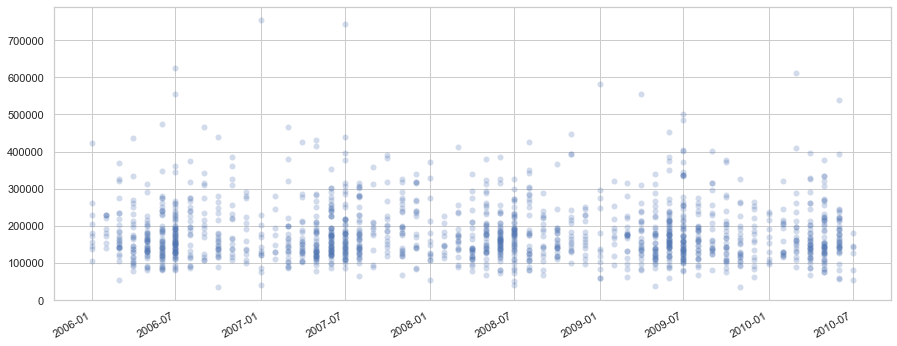

In [6]:
###############################################################################
#
# TIME PLOT:

    # let's get a first impression of our price-date data
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,6))
    # a bit of alpha to see vals overlap:
plt.scatter(sold.date, sold.price, alpha=0.25, linewidths=0)
    # give it a pretty date ax:
ax.fmt_xdata = DateFormatter('%Y-%m')
fig.autofmt_xdate()
    # and let's see:
plt.show()


In [7]:
###############################################################################
###############################################################################
###
#### NOTES: 
###
#
# impressionist plot shows: 
#     - density (= number of houses sold): varies over time: peaks in summers     
#     - price range: most houses between 10K and 30K, 
#                    only a handful prices >10K or >30K
#     - relation: prices also seem to increase during selling-season(=summer) 
#
###############################################################################

In [8]:
##############################################################################
##############################################################################
#
# STEP 3-2:
#          YEARLY SALES 
#                       - PRICES
#                       
###################################################
###################################################

# how many houses per year?

    # save count of houses per year to dict:
count_per_year = sold['year'].value_counts().to_dict()

        # order dict per year and per count:
per_year = collections.OrderedDict(sorted(count_per_year.items()))
per_count = collections.OrderedDict(sorted(count_per_year.items(), key=lambda t: t[1]))
            
        # let's see it:
print("sorted per year:\n",per_year,"\n\n sorted per number of houses sold:\n",per_count)

sorted per year:
 OrderedDict([(2006, 314), (2007, 329), (2008, 304), (2009, 338), (2010, 175)]) 

 sorted per number of houses sold:
 OrderedDict([(2010, 175), (2008, 304), (2006, 314), (2007, 329), (2009, 338)])


In [13]:
    # list for years
year_ids = [year for year in sold['year'].unique()]

    # dict
datedata = dict.fromkeys(year_ids)

In [14]:
    # temporary copy of df
temp = sold.copy()

In [15]:
    # func to return yearly data
def yearlydata(xyear):
    return temp.loc[temp["year"]== xyear]  

IndentationError: expected an indented block (<ipython-input-15-504a5ed41e3e>, line 3)

In [12]:
    # get yearly data
for xyear in year_ids:
    df =  yearlydata(xyear)
    datedata[xyear] = df 

IndentationError: expected an indented block (<ipython-input-12-f1bf5cafe891>, line 3)

In [25]:
    # save to temp df
# save to lists
tempcols = [y for y in year_ids]
tempindex = [x for x in range(13)]
tempdata = {}
# make df
temp = pd.DataFrame(data=tempdata,columns=tempcols)
temp['month'] = tempindex
temp = temp.set_index('month').drop(0)

In [26]:
# review yearid
for y in year_ids[:-1]:
    temp[y]=datedata[y].groupby('month').sum('price').get('price').to_list()
temp[2010] = [1638526, 2622350, 4266807, 6682417, 8564268, 6539025, 730500, 0, 0, 0, 0, 0]

In [28]:
##############################################################################
##############################################################################
#
# STEP 3-3: MONTHLY SALES
#                        - PRICES
# 
###################################################
###################################################
#

mos = sold.copy().reset_index()
mos = mos.assign(dti=mos.date).set_index('dti')

In [29]:
mondf1= pd.DataFrame(mos.groupby('date').price.agg('mean'))

mondf1['monthly_avg_price'] = mondf1['price'].round(2)

mondf1 = mondf1.reset_index().drop(columns={'price'})

prive_avg_monthly = mondf1.copy().drop(54)

prive_avg_monthly['year'] = prive_avg_monthly['date'].dt.year
prive_avg_monthly['month'] = prive_avg_monthly['date'].dt.month

prive_avg_monthly.tail(1)

,date,monthly_avg_price,year,month
53,2010-06-01,181639.58,2010,6


In [30]:
mondf2 = pd.DataFrame(mos.groupby('date').id.agg('count'))

mondf2['num_of_sales'] = mondf2['id']

num_monthly_sales = mondf2.copy().reset_index().drop(columns={'id'}).drop(54)

num_monthly_sales['year'] = num_monthly_sales['date'].dt.year
num_monthly_sales['month'] = num_monthly_sales['date'].dt.month

num_monthly_sales.tail(1)

,date,num_of_sales,year,month
53,2010-06-01,36,2010,6


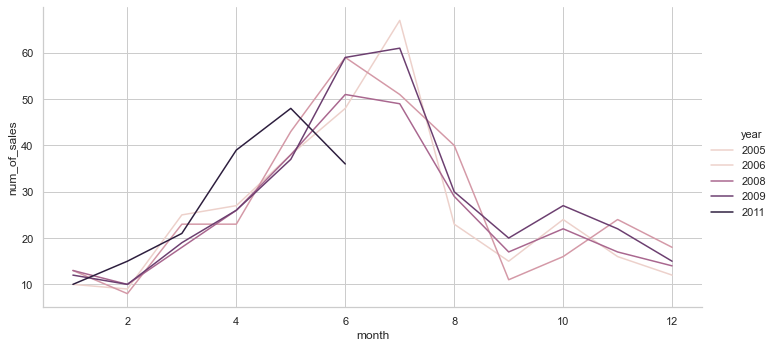

In [31]:
fig_monthly_sales = sns.relplot(x="month", y="num_of_sales", hue="year", kind="line", data=num_monthly_sales,aspect=12/6);


In [ ]:
###############################################################################
###############################################################################
###
#### NOTES: 
###
#
# plot shows: 
#     - assumed dependency price-month is encouraged
#     - peaks in summer-months
#
###############################################################################